# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result. 

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$. 

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

Google disk with data: https://drive.google.com/drive/folders/1K7KhHsOZHLgdLwQJuvkepQxKQOs-qSBa?usp=sharing

In [1]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html

Looking in links: https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
     |████████████████████████████████| 2.6MB 4.8MB/s 


In [42]:
!pip install ujson

     |████████████████████████████████| 184kB 5.0MB/s 


In [43]:
import glob
import json
import os
import shutil
import cv2
import torch
import time

import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import os.path as ops
import ujson as json

from torch_scatter import scatter
from torch.autograd import Variable
from sklearn.cluster import MeanShift, estimate_bandwidth
from tqdm import tqdm
from sklearn.linear_model import LinearRegression



## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In [3]:
ROOT_DIR = '/content/drive/MyDrive/data-cv/tusimple'

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download Tusimple Dataset

In [ ]:
!mkdir -p /content/drive/MyDrive/data-cv/tusimple
!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip
!unzip train_set.zip -d /content/drive/MyDrive/data-cv/tusimple

### Preprocess Tusimple Dataset Functions

In [ ]:
def get_image_to_folders(json_label_path, gt_image_dir, gt_binary_dir, gt_instance_dir, src_dir):
    image_nums = len(os.listdir(gt_image_dir))
    with open(json_label_path, 'r') as file:
        for line_index, line in enumerate(file):
            info_dict = json.loads(line)

            raw_file = info_dict['raw_file']
            h_samples = info_dict['h_samples']
            lanes = info_dict['lanes']

            image_path = ops.join(src_dir, raw_file)
            image_name_new = '{:s}.png'.format('{:d}'.format(line_index + image_nums).zfill(4))
            image_output_path = ops.join(ops.split(src_dir)[0], 'training', 'image', image_name_new)
            binary_output_path = ops.join(ops.split(src_dir)[0], 'training', 'segmentation_image', image_name_new)
            instance_output_path = ops.join(ops.split(src_dir)[0], 'training', 'instance_image', image_name_new)

            src_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            dst_binary_image = np.zeros([src_image.shape[0], src_image.shape[1]], np.uint8)
            dst_instance_image = np.zeros([src_image.shape[0], src_image.shape[1]], np.uint8)

            for lane_index, lane in enumerate(lanes):
                assert len(h_samples) == len(lane)
                lane_x = []
                lane_y = []
                for index in range(len(lane)):
                    if lane[index] == -2:
                        continue
                    else:
                        ptx = lane[index]
                        pty = h_samples[index]
                        lane_x.append(ptx)
                        lane_y.append(pty)
                if not lane_x:
                    continue
                lane_pts = np.vstack((lane_x, lane_y)).transpose()
                lane_pts = np.array([lane_pts], np.int64)

                cv2.polylines(dst_binary_image, lane_pts, isClosed=False, color=255, thickness=5)
                cv2.polylines(dst_instance_image, lane_pts, isClosed=False, color=lane_index * 50 + 20, thickness=5)

            cv2.imwrite(binary_output_path, dst_binary_image)
            cv2.imwrite(instance_output_path, dst_instance_image)
            cv2.imwrite(image_output_path, src_image)
        print('Process {:s} success'.format(json_label_path))

In [ ]:
def gen_train_sample(src_dir, b_gt_image_dir, i_gt_image_dir, image_dir):
    os.makedirs('{:s}/txt'.format(ops.split(src_dir)[0]), exist_ok=True)
    with open('{:s}/txt/train.txt'.format(ops.split(src_dir)[0]), 'w') as file:
        for image_name in os.listdir(b_gt_image_dir):
            if not image_name.endswith('.png'):
                continue
            binary_gt_image_path = ops.join(b_gt_image_dir, image_name)
            instance_gt_image_path = ops.join(i_gt_image_dir, image_name)
            image_path = ops.join(image_dir, image_name)

            b_gt_image = cv2.imread(binary_gt_image_path, cv2.IMREAD_COLOR)
            i_gt_image = cv2.imread(instance_gt_image_path, cv2.IMREAD_COLOR)
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)

            if b_gt_image is None or image is None or i_gt_image is None:
                print('Image set: {:s} broken'.format(image_name))
                continue
            else:
                info = '{:s} {:s} {:s}'.format(image_path, binary_gt_image_path, instance_gt_image_path)
                file.write(info + '\n')
    return

In [ ]:
def split_train_txt(src_dir):
    train_file_path =  '{:s}/txt/train.txt'.format(ops.split(src_dir)[0])
    test_file_path = '{:s}/txt/test.txt'.format(ops.split(src_dir)[0])
    valid_file_path = '{:s}/txt/val.txt'.format(ops.split(src_dir)[0])
    with open(train_file_path, 'r') as file:
        data = file.readlines()
        train_data = data[0:int(len(data)*0.8)]
        test_data = data[int(len(data)*0.8): int(len(data)*0.9)]
        valid_data = data[int(len(data) * 0.9): -1]
    with open(train_file_path, 'w') as file:
        for d in train_data:
            file.write(d)
    with open(test_file_path, 'w') as file:
        for d in test_data:
            file.write(d)
    with open(valid_file_path, 'w') as file:
        for d in valid_data:
            file.write(d)

In [ ]:
def process_tusimple_dataset(src_dir):
    traing_folder_path = ops.join(ops.split(src_dir)[0], 'training')
    os.makedirs(traing_folder_path, exist_ok=True)

    gt_image_dir = ops.join(traing_folder_path, 'image')
    gt_binary_dir = ops.join(traing_folder_path, 'segmentation_image')
    gt_instance_dir = ops.join(traing_folder_path, 'instance_image')

    os.makedirs(gt_image_dir, exist_ok=True)
    os.makedirs(gt_binary_dir, exist_ok=True)
    os.makedirs(gt_instance_dir, exist_ok=True)

    for json_label_path in glob.glob('{:s}/*.json'.format(src_dir)):
        get_image_to_folders(json_label_path, gt_image_dir, gt_binary_dir, gt_instance_dir, src_dir)
    gen_train_sample(src_dir, gt_binary_dir, gt_instance_dir, gt_image_dir)
    split_train_txt(src_dir)

In [ ]:
process_tusimple_dataset(ROOT_DIR)

### Class LaneDataset for Generate Train and Test examples

In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

In [4]:
DEFAULT_SIZE = (512, 256)
import torch


class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.size = size
        self.train = train

        self.img_pathes = []

        self.train_file = ops.join(dataset_path, 'train.txt')
        self.test_file = ops.join(dataset_path, 'test.txt')

        if self.train:
            file_open = self.train_file
        else:
            file_open = self.test_file

        with open(file_open, 'r') as file:
            data = file.readlines()
            for l in data:
                line = l.split()
                self.img_pathes.append(line)
        print(data[-1])

    def __getitem__(self, idx):
        if idx % 2 == 0:
            image = cv2.imread(self.img_pathes[int(idx/2)][0], cv2.IMREAD_UNCHANGED)
            segmentation_image = cv2.imread(self.img_pathes[int(idx/2)][1], cv2.IMREAD_UNCHANGED)
            instance_image = cv2.imread(self.img_pathes[int(idx/2)][2], cv2.IMREAD_UNCHANGED)
        else:
            image = cv2.imread(self.img_pathes[int((idx-1)/2)][0], cv2.IMREAD_UNCHANGED)
            segmentation_image = cv2.imread(self.img_pathes[int((idx-1)/2)][1], cv2.IMREAD_UNCHANGED)
            instance_image = cv2.imread(self.img_pathes[int((idx-1)/2)][2], cv2.IMREAD_UNCHANGED)

            image = cv2.flip(image, 1)
            segmentation_image = cv2.flip(segmentation_image, 1)
            instance_image = cv2.flip(instance_image, 1)

        image = cv2.resize(image, dsize=self.size, interpolation=cv2.INTER_LINEAR)
        segmentation_image = cv2.resize(segmentation_image, dsize=self.size, interpolation=cv2.INTER_NEAREST)
        instance_image = cv2.resize(instance_image, dsize=self.size, interpolation=cv2.INTER_NEAREST)



        image = image / 127.5 - 1.0
        segmentation_image = np.array(segmentation_image / 255.0, dtype=np.uint8)
        segmentation_image = segmentation_image[:, :, np.newaxis]
        instance_image = instance_image[:, :, np.newaxis]

        segmentation_image = np.transpose(segmentation_image, (2, 0, 1))
        instance_image = np.transpose(instance_image, (2, 0, 1))

        image = torch.tensor(image, dtype=torch.float)
        image = np.transpose(image, (2, 0, 1))

        segmentation_image = torch.tensor(segmentation_image, dtype=torch.long).view(self.size[1], self.size[0])
        instance_image = torch.tensor(instance_image, dtype=torch.long).view(self.size[1], self.size[0])

        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]
    
    def __len__(self):
        return len(self.img_pathes) * 2

### Check data in DataSet

In [5]:
DS_PATH = '/content/drive/MyDrive/data-cv/txt'

train_set = LaneDataset(dataset_path=DS_PATH, train=True)
test_set = LaneDataset(dataset_path=DS_PATH, train=False)

print('train_set length {}'.format(len(train_set)))

/content/drive/MyDrive/data-cv/training/image/2899.png /content/drive/MyDrive/data-cv/training/segmentation_image/2899.png /content/drive/MyDrive/data-cv/training/instance_image/2899.png

/content/drive/MyDrive/data-cv/training/image/3262.png /content/drive/MyDrive/data-cv/training/segmentation_image/3262.png /content/drive/MyDrive/data-cv/training/instance_image/3262.png

train_set length 5800


In [6]:
image, segmentation, instance = train_set[100]

print('image type {}'.format(type(image)))
print('image size {} \n'.format(image.size()))

print('binary image type {}'.format(type(segmentation)))
print('binary image size {}'.format(segmentation.size()))
print('items in binary image {} \n'.format(torch.unique(segmentation)))

print('instance type {}'.format(type(instance)))
print('instance size {}'.format(instance.size()))
print('items in instance {} \n'.format(torch.unique(instance)))

image type <class 'torch.Tensor'>
image size torch.Size([3, 256, 512]) 

binary image type <class 'torch.Tensor'>
binary image size torch.Size([256, 512])
items in binary image tensor([0, 1]) 

instance type <class 'torch.Tensor'>
instance size torch.Size([256, 512])
items in instance tensor([  0,  20,  70, 120, 170]) 



In [7]:
image_show = ((image.numpy() + 1) * 127.5).astype(int)
image_show.shape

(3, 256, 512)

### Show example of image

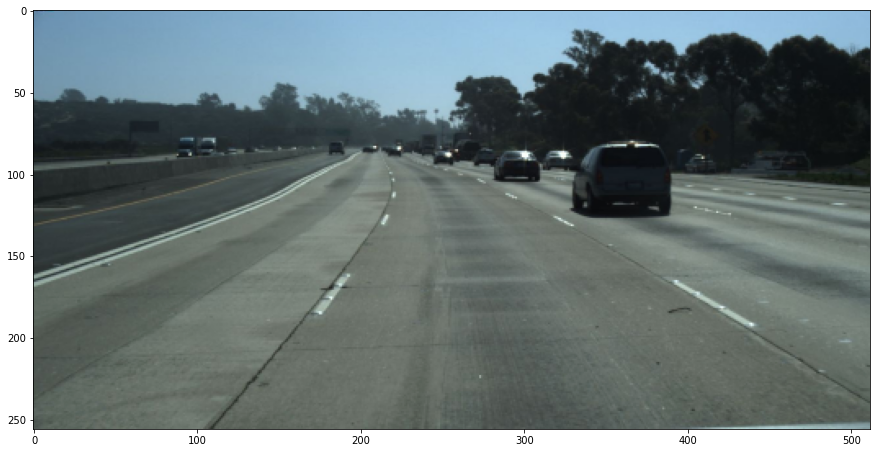

In [8]:
plt.figure(figsize=(15,15))
image_show = image_show.transpose(1,2,0)
image_show = image_show[...,::-1]
plt.imshow(image_show)

In [9]:
segmentation.shape

torch.Size([256, 512])

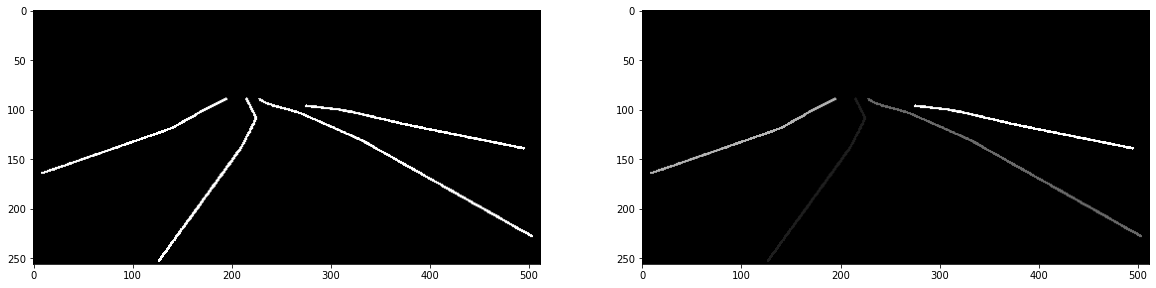

In [10]:
plt.figure(figsize=(20,20))
ax1 = plt.subplot(121)
plt.imshow(segmentation, cmap='gray')

ax1 = plt.subplot(122)
plt.imshow(instance, cmap='gray')

### Do ENet architecture

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

### Helper classes for ENet

In [11]:
class InitialBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bias=False, relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        self.main_branch = nn.Conv2d(in_channels, out_channels - 3, kernel_size=3, stride=2, padding=1, bias=bias)
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        out = torch.cat((main, ext), 1)
        out = self.batch_norm(out)

        return self.out_activation(out)


In [12]:
class RegularBottleneck(nn.Module):
    def __init__(self, channels, internal_ratio=4, kernel_size=3, padding=0, dilation=1, asymmetric=False, dropout_prob=0, bias=False, relu=True):
        super().__init__()

        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}."
                               .format(channels, internal_ratio))

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        self.ext_conv1 = nn.Sequential(nn.Conv2d(channels, internal_channels, kernel_size=1, stride=1, bias=bias), nn.BatchNorm2d(internal_channels), activation())

        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(internal_channels, internal_channels, kernel_size=(kernel_size, 1), stride=1, padding=(padding, 0), dilation=dilation, bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(internal_channels, internal_channels, kernel_size=(1, kernel_size), stride=1, padding=(0, padding), dilation=dilation, bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(nn.Conv2d(internal_channels, internal_channels, kernel_size=kernel_size, stride=1, padding=padding, dilation=dilation, bias=bias), nn.BatchNorm2d(internal_channels), activation())

        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(internal_channels, channels, kernel_size=1, stride=1, bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)
        self.out_activation = activation()

    def forward(self, x):
        main = x

        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        out = main + ext

        return self.out_activation(out)

In [13]:
class DownsamplingBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, internal_ratio=4, return_indices=False, dropout_prob=0, bias=False, relu=True):
        super().__init__()

        self.return_indices = return_indices

        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        self.main_max1 = nn.MaxPool2d(2, stride=2, return_indices=return_indices)

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(nn.Conv2d(in_channels, internal_channels, kernel_size=2, stride=2, bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(nn.Conv2d(internal_channels, internal_channels, kernel_size=3, stride=1, padding=1, bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(nn.Conv2d(internal_channels, out_channels, kernel_size=1, stride=1, bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)
        self.out_activation = activation()

    def forward(self, x):
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices


In [14]:
class UpsamplingBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, internal_ratio=4, dropout_prob=0, bias=False, relu=True):
        super().__init__()

        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError("Value out of range. Expected value in the "
                               "interval [1, {0}], got internal_scale={1}. "
                               .format(in_channels, internal_ratio))

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias), nn.BatchNorm2d(out_channels))

        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(nn.Conv2d(in_channels, internal_channels, kernel_size=1, bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(internal_channels, internal_channels, kernel_size=2, stride=2, bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(nn.Conv2d(internal_channels, out_channels, kernel_size=1, bias=bias), nn.BatchNorm2d(out_channels))
        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

### ENet Main class

In [15]:
class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        self.initial_block = InitialBlock(3, 16, relu=encoder_relu)

        # Stage 1 share
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Stage 2 share
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 binary
        self.regular_binary_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # stage 3 embedding
        self.regular_embedding_3_0 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_1 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_2 = RegularBottleneck(128, kernel_size=5, padding=2, asymmetric=True, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_3 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_4 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_5 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_bembedding_3_6 = RegularBottleneck(128, kernel_size=5, asymmetric=True, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_7 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # binary branch
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)

        # embedding branch
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # Initial block
        input_size = x.size()
        x = self.initial_block(x)

        # Stage 1 share
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Stage 2 share
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # stage 3 binary
        x_binary = self.regular_binary_3_0(x)
        x_binary = self.dilated_binary_3_1(x_binary)
        x_binary = self.asymmetric_binary_3_2(x_binary)
        x_binary = self.dilated_binary_3_3(x_binary)
        x_binary = self.regular_binary_3_4(x_binary)
        x_binary = self.dilated_binary_3_5(x_binary)
        x_binary = self.asymmetric_binary_3_6(x_binary)
        x_binary = self.dilated_binary_3_7(x_binary)

        # stage 3 embedding
        x_embedding = self.regular_embedding_3_0(x)
        x_embedding = self.dilated_embedding_3_1(x_embedding)
        x_embedding = self.asymmetric_embedding_3_2(x_embedding)
        x_embedding = self.dilated_embedding_3_3(x_embedding)
        x_embedding = self.regular_embedding_3_4(x_embedding)
        x_embedding = self.dilated_embedding_3_5(x_embedding)
        x_embedding = self.asymmetric_bembedding_3_6(x_embedding)
        x_embedding = self.dilated_embedding_3_7(x_embedding)

        # binary branch
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # embedding branch
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)
        instance_notfinal_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_notfinal_logits

### DiscriminativeLoss

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [ ]:
class DiscriminativeLoss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=True):
        super(DiscriminativeLoss, self).__init__(size_average=size_average)
        # TODO

    def forward(self, input, target):
        # TODO
        pass

In [16]:
class cluster_loss_helper(nn.Module):
    def __init__(self):
        super(cluster_loss_helper, self).__init__()

    def forward(self, prediction, correct_label, delta_v, delta_d):
        prediction_reshape = prediction.view(prediction.shape[0], prediction.shape[1], prediction.shape[2] * prediction.shape[3])  # [N, 4, 131072]
        correct_label_reshape = correct_label.view(correct_label.shape[0], 1, correct_label.shape[1] * correct_label.shape[2])  # [N, 1, 131072]

        output, inverse_indices, counts = torch.unique(correct_label_reshape, return_inverse=True, return_counts=True)
        counts = counts.float()
        num_instances = len(output)

        muc = scatter(prediction_reshape, inverse_indices, dim=2, reduce="mean")  # [N, 4, 5]

        dis = torch.index_select(muc, 2, inverse_indices.view(inverse_indices.shape[-1]),
                                 out=None)  # [N, 4, 131072]
        dis = dis - prediction_reshape
        dis = torch.norm(dis, dim=1, keepdim=False, out=None, dtype=None)  # [N, 131072]
        dis = dis - delta_v
        dis = torch.clamp(dis, min=0.)  # [N, 131072]
        dis = torch.pow(dis, 2, out=None)

        L_var = scatter(dis, inverse_indices.view(inverse_indices.shape[-1]), dim=1, reduce="mean")  # [N, 3]
        L_var = torch.sum(L_var) / num_instances

        L_dist = torch.tensor(0, dtype=torch.float)
        for A in range(num_instances):
            for B in range(num_instances):
                if A != B:
                    dis = muc[:, :, A] - muc[:, :, B]
                    dis = torch.norm(dis, dim=1, keepdim=False, out=None, dtype=None)
                    dis = delta_d - dis
                    dis = torch.clamp(dis, min=0.)
                    dis = torch.pow(dis, 2, out=None)
                    L_dist = L_dist + dis
        L_dist = L_dist / (num_instances * (num_instances - 1))
        L_dist = L_dist.view([])
        total_loss = L_var + L_dist
        return total_loss


class cluster_loss(nn.Module):
    def __init__(self):
        super(cluster_loss, self).__init__()

    def forward(self, binary_logits, binary_labels, instance_logits, instance_labels, delta_v=0.5, delta_d=3):
        output, counts = torch.unique(binary_labels, return_inverse=False, return_counts=True)
        counts = counts.float()
        inverse_weights = torch.div(1.0, torch.log(
            torch.add(torch.div(counts, torch.sum(counts)), torch.tensor(1.02, dtype=torch.float))))

        binary_loss = torch.nn.CrossEntropyLoss(weight=inverse_weights)
        binary_segmenatation_loss = binary_loss(binary_logits, binary_labels)

        batch_size = instance_logits.shape[0]
        loss_set = []
        for dimen in range(batch_size):
            loss_set.append(cluster_loss_helper())

        instance_segmenatation_loss = torch.tensor(0.)#.cuda()

        for dimen in range(batch_size):
            instance_loss = loss_set[dimen]
            prediction = torch.unsqueeze(instance_logits[dimen], 0) # .cuda()
            correct_label = torch.unsqueeze(instance_labels[dimen], 0)# .cuda()
            instance_segmenatation_loss += instance_loss(prediction, correct_label, delta_v, delta_d)

        instance_segmenatation_loss = instance_segmenatation_loss / batch_size
        return binary_segmenatation_loss, instance_segmenatation_loss

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [17]:
batch_size = 8

data_loader_train = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
data_loader_test = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

In [18]:
learning_rate = 5e-4

In [21]:
device = torch.device('cpu')

ENet_model = ENet(2, 4)
ENet_model.to(device)

params = [p for p in ENet_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=learning_rate, weight_decay=0.0002)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [22]:
device

device(type='cpu')

In [23]:
num_epochs = 40
criterion = cluster_loss()

In [24]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [25]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 37.9 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
loss_all = []

for epoch in range(num_epochs):
    ENet_model.train()
    ts = time.time()

    for iter, batch in enumerate(data_loader_train):
        input_image = Variable(batch[0]).to(device)
        binary_labels = Variable(batch[1]).to(device)
        instance_labels = Variable(batch[2]).to(device)
        
        binary_final_logits, instance_embedding = ENet_model(input_image)
        binary_segmenatation_loss, instance_segmenatation_loss = criterion(binary_logits=binary_final_logits, binary_labels=binary_labels,
                                       instance_logits=instance_embedding, instance_labels=instance_labels, delta_v=0.5, delta_d=3)
        
        loss = 1*binary_segmenatation_loss + 1*instance_segmenatation_loss
        optimizer.zero_grad()
        loss_all.append(loss.item())
        loss.backward()
        optimizer.step()
        
        if iter % 40 == 0:
            print("epoch[{}] iter[{}] loss: [{}, {}] ".format(epoch, iter, binary_segmenatation_loss.item(), instance_segmenatation_loss.item()))
    
    lr_scheduler.step()
    print("Finish epoch[{}], time elapsed[{}]".format(epoch, time.time() - ts))
    torch.save(ENet_model.state_dict(), f'/content/drive/MyDrive/data-cv/enet_epoch_{epoch}_batch_{8}.model')

In [ ]:
# TODO: Train segmentation and instance segmentation

## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [ ]:
HNET_DEFAULT_SIZE = (64, 128)
import torch

class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        # TODO
        pass

    def __getitem__(self, idx):
        # TODO
        return image, ground_truth_trajectory
    
    def __len__(self):
        # TODO
        pass

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [ ]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [ ]:
# !wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

In [ ]:
from matplotlib import pyplot as plt
import cv2

In [ ]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')

In [ ]:
image = cv2.resize(image, (128, 64))

In [ ]:
plt.imshow(image)

In [ ]:
R_np = R.numpy()

In [ ]:
[]

In [ ]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [ ]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        # TODO
    def forward(self, x):
      # TODO
      pass

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through. 
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [ ]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=True):
        super(HomographyLoss, self).__init__(size_average=size_average)

    def forward(self, input, target):
        # TODO
        pass

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [ ]:
# Train the H-Net

# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [ ]:
class LaneDetector:
  def __init__(self, hnet, lanenet):
    pass
  
  def __call__(self, image, y_positions):
    pass

In [28]:
model_path = '/content/drive/MyDrive/data-cv/model/enet_epoch_39_batch_8.model'
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ENet_model = ENet(2, 4)
ENet_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
ENet_model.to(device)

ENet(
  (initial_block): InitialBlock(
    (main_branch): Conv2d(3, 13, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (ext_branch): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (batch_norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (out_activation): PReLU(num_parameters=1)
  )
  (downsample1_0): DownsamplingBottleneck(
    (main_max1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (ext_conv1): Sequential(
      (0): Conv2d(16, 4, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_conv2): Sequential(
      (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): PReLU(num_parameters=1)
    )
    (ext_c

In [29]:
!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/test_set.zip
!unzip test_set.zip -d /content/drive/MyDrive/data-cv/tusimple

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/data-cv/tusimple/clips/0530/1492626847734235723_0/20.jpg  
  inflating: /content/drive/MyDrive/data-cv/tusimple/clips/0530/1492626847734235723_0/19.jpg  
  inflating: /content/drive/MyDrive/data-cv/tusimple/clips/0530/1492626847734235723_0/18.jpg  
  inflating: /content/drive/MyDrive/data-cv/tusimple/clips/0530/1492626847734235723_0/17.jpg  
  inflating: /content/drive/MyDrive/data-cv/tusimple/clips/0530/1492626847734235723_0/16.jpg  
  inflating: /content/drive/MyDrive/data-cv/tusimple/clips/0530/1492626847734235723_0/15.jpg  
  inflating: /content/drive/MyDrive/data-cv/tusimple/clips/0530/1492626847734235723_0/14.jpg  
  inflating: /content/drive/MyDrive/data-cv/tusimple/clips/0530/1492626847734235723_0/13.jpg  
  inflating: /content/drive/MyDrive/data-cv/tusimple/clips/0530/1492626847734235723_0/12.jpg  
  inflating: /content/drive/MyDrive/data-cv/tusimple/clips/0530/1492626847734235723_0/11.jpg  

In [31]:
pred_json_path = '/content/drive/MyDrive/data-cv/tusimple/test_tasks_0627.json'
json_pred = [json.loads(line) for line in open(pred_json_path).readlines()]

In [35]:
def process_instance_embedding(instance_embedding, binary_img, distance=1, lane_num=5):
    embedding = instance_embedding[0].detach().numpy().transpose(1, 2, 0)
    cluster_result = np.zeros(binary_img.shape, dtype=np.int32)
    cluster_list = embedding[binary_img > 0]
    mean_shift = MeanShift(bandwidth=distance, bin_seeding=True, n_jobs=-1)
    mean_shift.fit(cluster_list)
    labels = mean_shift.labels_

    cluster_result[binary_img > 0] = labels + 1
    cluster_result[cluster_result > lane_num] = 0
    for idx in np.unique(cluster_result):
        if len(cluster_result[cluster_result == idx]) < 15:
            cluster_result[cluster_result == idx] = 0

    H, W = binary_img.shape
    rbg_emb = np.zeros((H, W, 3))
    color = [[0, 0, 0], [255, 0, 0], [0, 255, 0], [0, 0, 255], [255, 215, 0], [0, 255, 255]]
    element = np.unique(cluster_result)
    for i in range(len(element)):
        rbg_emb[cluster_result == element[i]] = color[i]

    return rbg_emb / 255, cluster_result

In [38]:
all_time_forward = []
all_time_clustering = []

for i, sample in enumerate(tqdm(json_pred)):
    h_samples = sample['h_samples']
    lanes = sample['lanes']
    run_time = sample['run_time']
    raw_file = sample['raw_file']
    img_path = ops.join('/content/drive/MyDrive/data-cv/tusimple', raw_file)

    # read the image
    gt_img_org = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    org_shape = gt_img_org.shape
    gt_image = cv2.resize(gt_img_org, dsize=(512, 256), interpolation=cv2.INTER_LINEAR)
    gt_image = gt_image / 127.5 - 1.0
    gt_image = torch.tensor(gt_image, dtype=torch.float)
    gt_image = np.transpose(gt_image, (2, 0, 1))

    # Go through the network
    time_start = time.time()
    binary_final_logits, instance_embedding = ENet_model(gt_image.unsqueeze(0))
    time_end=time.time()

    # Get the final embedding image
    binary_img = torch.argmax(binary_final_logits, dim=1).squeeze().cpu().numpy()
    binary_img[0:50,:] = 0
    clu_start = time.time()
    rbg_emb, cluster_result = process_instance_embedding(instance_embedding.cpu(), binary_img, distance=1.5, lane_num=4)
    clu_end = time.time()
    cluster_result = cv2.resize(cluster_result, dsize=(org_shape[1], org_shape[0]), interpolation=cv2.INTER_NEAREST)
    elements = np.unique(cluster_result)
    
    for line_idx in elements:
        if line_idx == 0:
            continue
        else:
            mask = (cluster_result == line_idx)
            select_mask = mask[h_samples]
            row_result = []
            for row in range(len(h_samples)):
                col_indexes = np.nonzero(select_mask[row])[0]
                if len(col_indexes) == 0:
                    row_result.append(-2)
                else:
                    row_result.append(int(col_indexes.min() + (col_indexes.max()-col_indexes.min())/2))
            json_pred[i]['lanes'].append(row_result)
            json_pred[i]['run_time'] = time_end-time_start
            all_time_forward.append(time_end-time_start)
            all_time_clustering.append(clu_end-clu_start)

100%|██████████| 2782/2782 [46:16<00:00,  1.00it/s]


In [39]:
with open('/content/drive/MyDrive/data-cv/pred.json', 'w') as f:
    for res in json_pred:
        json.dump(res, f)
        f.write('\n')

In [49]:
class Eval(object):
    lr = LinearRegression()
    pixel_thresh = 20
    pt_thresh = 0.85

    @staticmethod
    def get_angle(xs, y_samples):
        xs, ys = xs[xs >= 0], y_samples[xs >= 0]

        if len(xs) > 1:
            Eval.lr.fit(ys[:, None], xs)
            k = Eval.lr.coef_[0]
            theta = np.arctan(k)
        else:
            theta = 0

        return theta

    @staticmethod
    def line_accuracy(pred, gt, thresh):
        pred = np.array([p if p >= 0 else -100 for p in pred])
        gt = np.array([g if g >= 0 else -100 for g in gt])

        return np.sum(np.where(np.abs(pred - gt) < thresh, 1., 0.)) / len(gt)

    @staticmethod
    def bench(pred, gt, y_samples, running_time):
        if any(len(p) != len(y_samples) for p in pred):
            raise Exception('Format of lanes error.')

        if running_time > 200 or len(gt) + 2 < len(pred):
            return 0., 0., 1.

        angles = [Eval.get_angle(np.array(x_gts), np.array(y_samples)) for x_gts in gt]
        threshs = [Eval.pixel_thresh / np.cos(angle) for angle in angles]
        line_accs = []
        fp, fn = 0., 0.
        matched = 0.

        for x_gts, thresh in zip(gt, threshs):
            accs = [Eval.line_accuracy(np.array(x_preds), np.array(x_gts), thresh) for x_preds in pred]
            max_acc = np.max(accs) if len(accs) > 0 else 0.
            if max_acc < Eval.pt_thresh:
                fn += 1
            else:
                matched += 1

            line_accs.append(max_acc)

        fp = len(pred) - matched

        if len(gt) > 4 and fn > 0:
            fn -= 1
        s = sum(line_accs)
        if len(gt) > 4:
            s -= min(line_accs)
        return s / max(min(4.0, len(gt)), 1.), fp / len(pred) if len(pred) > 0 else 0., fn / max(min(len(gt), 4.) , 1.)

    @staticmethod
    def bench_one_submit(pred_file, gt_file):
        try:
            json_pred = [json.loads(line) for line in open(pred_file).readlines()]
        except BaseException as e:
            raise Exception('Fail to load json file of the prediction.')

        json_gt = [json.loads(line) for line in open(gt_file).readlines()]
        if len(json_gt) != len(json_pred):
            raise Exception('We do not get the predictions of all the test tasks')

        gts = {l['raw_file']: l for l in json_gt}
        accuracy, fp, fn = 0., 0., 0.

        for pred in json_pred:
            if 'raw_file' not in pred or 'lanes' not in pred: #or 'run_time' not in pred:
                raise Exception('raw_file or lanes or run_time not in some predictions.')
            raw_file = pred['raw_file']
            pred_lanes = pred['lanes']
            run_time = 100
            if raw_file not in gts:
                raise Exception('Some raw_file from your predictions do not exist in the test tasks.')

            gt = gts[raw_file]
            gt_lanes = gt['lanes']
            y_samples = gt['h_samples']
            try:
                a, p, n = Eval.bench(pred_lanes, gt_lanes, y_samples, run_time)
            except BaseException as e:
                raise Exception('Format of lanes error.')

            accuracy += a
            fp += p
            fn += n

        num = len(gts)

        return json.dumps([
            {'name': 'Accuracy', 'value': accuracy / num, 'order': 'desc'},
            {'name': 'FP', 'value': fp / num, 'order': 'asc'},
            {'name': 'FN', 'value': fn / num, 'order': 'asc'}
        ])

In [50]:
result = Eval.bench_one_submit('/content/drive/MyDrive/data-cv/pred.json', pred_json_path)

In [52]:
result

'[{"name":"Accuracy","value":0.0,"order":"desc"},{"name":"FP","value":0.0010783608914450035,"order":"asc"},{"name":"FN","value":0.998921639108555,"order":"asc"}]'